# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Makw 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of x:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of x:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [6]:
# check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

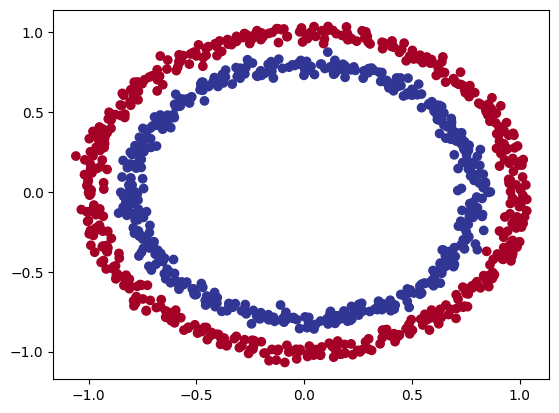

In [7]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);


**Note:** the data we're working with is often reffered to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

### 1.1 chech input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [10]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [11]:
import torch
torch.__version__

'2.1.2+cpu'

In [12]:
type(X)

numpy.ndarray

In [13]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [14]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [15]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                     y,
                                                     test_size=0.2, # 0.2 = 20% data will be test and 80% will be train
                                                     random_state = 42)

In [16]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [17]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. setup a device agonistic code so our code will run on a accelerator (GPU) if there is one.
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [18]:
import torch
from torch import nn 

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of our model
4. Instatiate an instance of our model class and send it to the target `device`

**we can also put this below written code into a python file and just import and call it which will make it easy for us than writing this code again and again**

In [19]:
# 1. Construct a model that subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features = 2, out_features = 5) # takes in 2 featuers and upscales to 5 features
        self.layer_2 = nn.Linear(in_features = 5, out_features = 1) # out_features of layer_1 must match in_features of layer_2

    # 3. Define the forward method, take in a tensor and returns a tensor with predictions
    def forward(self, X):
        return self.layer_2(self.layer_1(X)) # X -> layer_1 -> layer_2 -> output

# 4. instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
device

'cpu'

**we dont have a GPU currently in out machine thats why its dufault to run on CPU**

In [21]:
next(model_0.parameters()).device

device(type='cpu')

In [22]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)

).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 5.2869e-05,  2.8003e-01],
                      [-5.7005e-01,  1.6091e-01],
                      [-2.4243e-01, -3.5867e-01],
                      [-2.3080e-01,  6.3140e-01],
                      [-1.3776e-01, -5.7359e-01]])),
             ('0.bias', tensor([-0.5505, -0.6366,  0.0548,  0.6417, -0.4518])),
             ('1.weight',
              tensor([[ 0.2502,  0.3587, -0.1009,  0.1429, -0.0798]])),
             ('1.bias', tensor([0.0430]))])

In [24]:
#Make some predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {torch.round(untrained_preds[:10])}")
print(f"First 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[ 0.],
        [ 0.],
        [-0.],
        [ 0.],
        [-1.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [ 0.]])
First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 setup loss function and optimizer

Which loss function or optimizer should we use?

Again... this is problem specific.

For example: for regression we used MAE or MSE (mean absolute error or mean square error).

for classification we might want binary cross entropy or categorical cross entropy (cross entropy)

As a reminder, the loss function measures how *wrong* our model's predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`, for more on what is binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a?gi=b281c3081af8
* For different optimizers - `torch.optim` on google 

In [25]:
# setup a loss function
# loss_fn = nn.BCELoss() # Binary Cross Entropy Loss
loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits Loss

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

In [26]:
model_0.state_dict()


OrderedDict([('0.weight',
              tensor([[ 5.2869e-05,  2.8003e-01],
                      [-5.7005e-01,  1.6091e-01],
                      [-2.4243e-01, -3.5867e-01],
                      [-2.3080e-01,  6.3140e-01],
                      [-1.3776e-01, -5.7359e-01]])),
             ('0.bias', tensor([-0.5505, -0.6366,  0.0548,  0.6417, -0.4518])),
             ('1.weight',
              tensor([[ 0.2502,  0.3587, -0.1009,  0.1429, -0.0798]])),
             ('1.bias', tensor([0.0430]))])

In [27]:
# calculate accuracy = out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## 3. Train Model

To train our model, we're going to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. optimizer zero grad
4. loss backward ( backpropagation )
5. optimizer step (gradient descent) 

### 3.1 Going from raw logits -> predictions probabilities -> prediction labels

Our model outputs are going to be **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [28]:
# view the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0797],
        [ 0.0840],
        [-0.1533],
        [ 0.1466],
        [-0.5053]])

In [29]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [30]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5199],
        [0.5210],
        [0.4617],
        [0.5366],
        [0.3763]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_prob` >=0.5, `y=1` (class 1) -> we can also change these `0.5` values but generally they are setuped at 0.5
* `y_pred_prob` <0.5, `y=0` (class 0)


In [31]:
# Find the predicted labels based on our model probabilities
y_preds = torch.round(y_pred_probs)

# in full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of the extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 0., 1., 0.])

In [32]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100

# put data to target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loops
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # sigmoid converts logits into prediction probabilities then into prediction labels

    # 2. calculate loss accuracy
    '''loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
                   y_train)'''
    
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss() doesn't expect probabilities (hence the name with "logits")
                   y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)

    # 3. zero the gradients
    optimizer.zero_grad()

    # 4. backward pass (backpropagation)
    loss.backward()

    # 5. step the optimizer and update the weights (gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate the test loss and accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)

    # print out what happening'
    if epoch % 10 ==0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Train accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
    


Epoch: 0 | Train loss: 0.70402 | Train accuracy: 48.38% | Test loss: 0.70701 | Test accuracy: 44.00%
Epoch: 10 | Train loss: 0.69938 | Train accuracy: 48.50% | Test loss: 0.70335 | Test accuracy: 50.50%
Epoch: 20 | Train loss: 0.69753 | Train accuracy: 48.62% | Test loss: 0.70173 | Test accuracy: 49.50%
Epoch: 30 | Train loss: 0.69655 | Train accuracy: 49.62% | Test loss: 0.70068 | Test accuracy: 49.50%
Epoch: 40 | Train loss: 0.69590 | Train accuracy: 49.75% | Test loss: 0.69984 | Test accuracy: 50.50%
Epoch: 50 | Train loss: 0.69542 | Train accuracy: 50.12% | Test loss: 0.69914 | Test accuracy: 50.00%
Epoch: 60 | Train loss: 0.69503 | Train accuracy: 50.62% | Test loss: 0.69853 | Test accuracy: 49.50%
Epoch: 70 | Train loss: 0.69472 | Train accuracy: 50.62% | Test loss: 0.69801 | Test accuracy: 49.50%
Epoch: 80 | Train loss: 0.69447 | Train accuracy: 50.25% | Test loss: 0.69756 | Test accuracy: 49.50%
Epoch: 90 | Train loss: 0.69425 | Train accuracy: 50.25% | Test loss: 0.69717 | Tes

In [34]:
loss_fn

BCEWithLogitsLoss()

In [35]:
loss_fn_without_logits = nn.BCELoss()
loss_fn_without_logits

BCELoss()

## 4. Make predicitons and evaluate the model

from the metrics it looks like our model isn't learning anything...

so to inspect it let's make some predictions and make them visual.

in other words, "Visualize, visualize,visualize!"

To do so, we're going to import a function called `plot_decision_boundary()`

In [36]:
import requests
from pathlib import Path

if Path("/workspaces/codespaces-jupyter/notebooks/helper_functions.py").is_file():
    print("helper_functions.py exists, skipping download")
else:
    print("Downloading helper_functions.py...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)


from helper_functions import plot_predictions, plot_decision_boundary

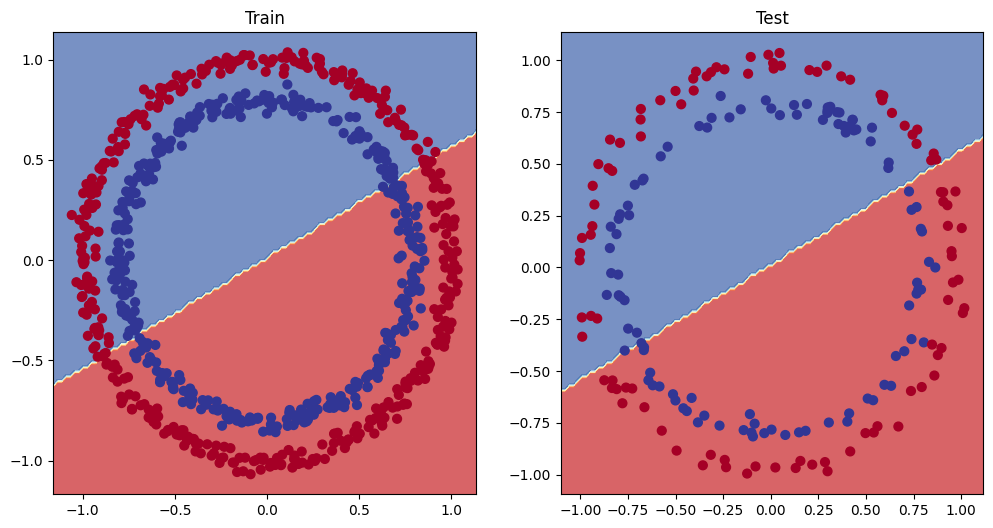

In [37]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* fir for longer
* changing the activation functions
* changing the learning rate
* Chnage the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values(as machine learning engineers and data scientists) can change, they are called **Hyperparameters**

Let's try and improve our model by:
* Adding more hidden units: 5->10
* increase the number of layers: 2->3
* increase the number of epochs: 100->1000

**Change one value at a time**

In [38]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features = 2, out_features=10)
        self.layer_2 = nn.Linear(in_features = 10, out_features=10)
        self.layer_3 = nn.Linear(in_features = 10, out_features=1)

    def forward(self,X):
      # z = self.layer_1(X)
       # z = self.layer_2(z)
       # z = self.layer_3(z) 
       return self.layer_3(self.layer_2(self.layer_1(X))) # this way of writing operations levrages speed ups where possible behind the scenes
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [39]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()


# create an optimizer
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr=0.1)

In [40]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# train for longer
epochs = 1000

# put data to target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # sigmoid converts logits into prediction probabilities then into prediction labels

    # 2. calculate loss accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                      y_pred = y_pred)
    
    # 3. zero the gradients
    optimizer.zero_grad()

    # 4. backward pass (backpropagation)
    loss.backward()

    # 5. step the optimizer and update the weights (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate the test loss and accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_true = y_test,
                               y_pred = test_pred)
        
    # print out what happening'
    if epoch % 100 ==0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Train accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")



Epoch: 0 | Train loss: 0.69396 | Train accuracy: 50.88% | Test loss: 0.79303 | Test accuracy: 50.00%


Epoch: 100 | Train loss: 0.69298 | Train accuracy: 51.50% | Test loss: 0.69470 | Test accuracy: 45.50%
Epoch: 200 | Train loss: 0.69317 | Train accuracy: 48.62% | Test loss: 0.69500 | Test accuracy: 45.50%
Epoch: 300 | Train loss: 0.69298 | Train accuracy: 51.12% | Test loss: 0.69468 | Test accuracy: 46.00%
Epoch: 400 | Train loss: 0.69298 | Train accuracy: 51.00% | Test loss: 0.69468 | Test accuracy: 46.00%
Epoch: 500 | Train loss: 0.69298 | Train accuracy: 51.00% | Test loss: 0.69468 | Test accuracy: 46.00%
Epoch: 600 | Train loss: 0.69298 | Train accuracy: 51.00% | Test loss: 0.69468 | Test accuracy: 46.00%
Epoch: 700 | Train loss: 0.69298 | Train accuracy: 51.00% | Test loss: 0.69468 | Test accuracy: 46.00%
Epoch: 800 | Train loss: 0.69298 | Train accuracy: 51.00% | Test loss: 0.69468 | Test accuracy: 46.00%
Epoch: 900 | Train loss: 0.69298 | Train accuracy: 51.00% | Test loss: 0.69468 | Test accuracy: 46.00%


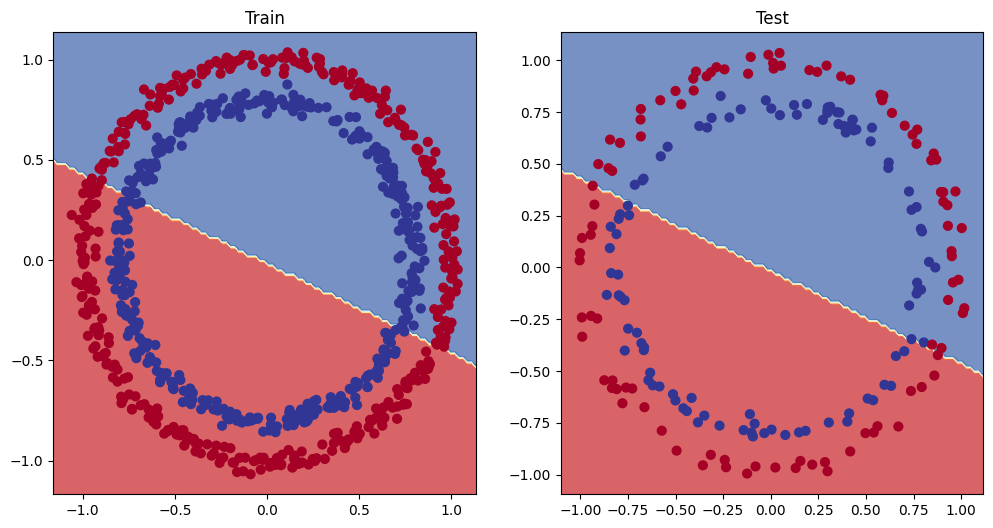

In [41]:
# plot the decision boundary for model_1
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem

In [42]:
# Create some data ( same as notebook 01)
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

# create data
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# check out the data
print(len(X_regression))
X_regression[:5], y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [43]:
# Create train and test splits
train_split = int(0.8 *len(X_regression)) # 80% of data for training
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

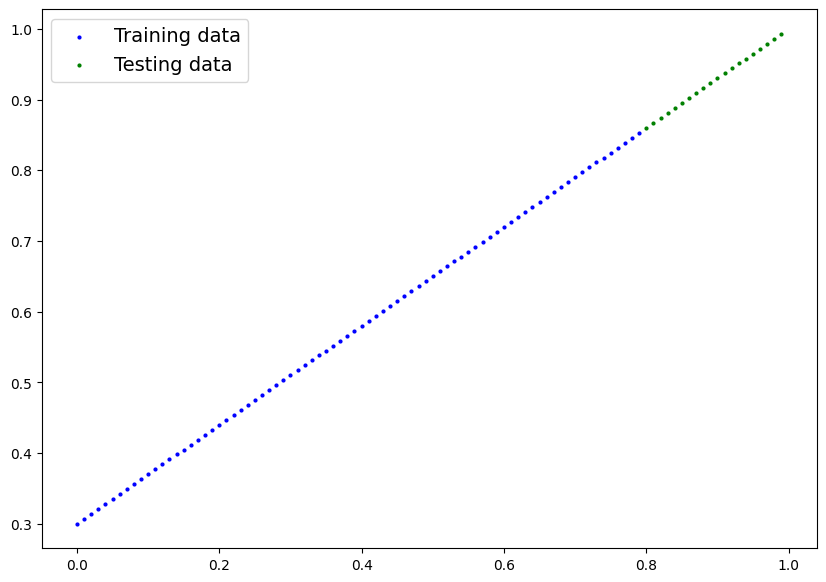

In [44]:
# Plot the data
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)


### 5.2 adjust `model_1` to fit a straight line

In [45]:
# same architecture as model_1 ( but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features = 1, out_features = 10),
    nn.Linear(in_features = 10, out_features = 10),
    nn.Linear(in_features = 10, out_features = 1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [46]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                             lr=0.01)

In [47]:
# Train model
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# set the no. of epochs
epochs = 1000

# put data to target device
X_train_regression,y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression,y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)


    # print out what happening'
    if epoch % 100 ==0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986 | Test loss: 0.91103


Epoch: 100 | Train loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Train loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Train loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Train loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Train loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Train loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Train loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Train loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Train loss: 0.01798 | Test loss: 0.00360


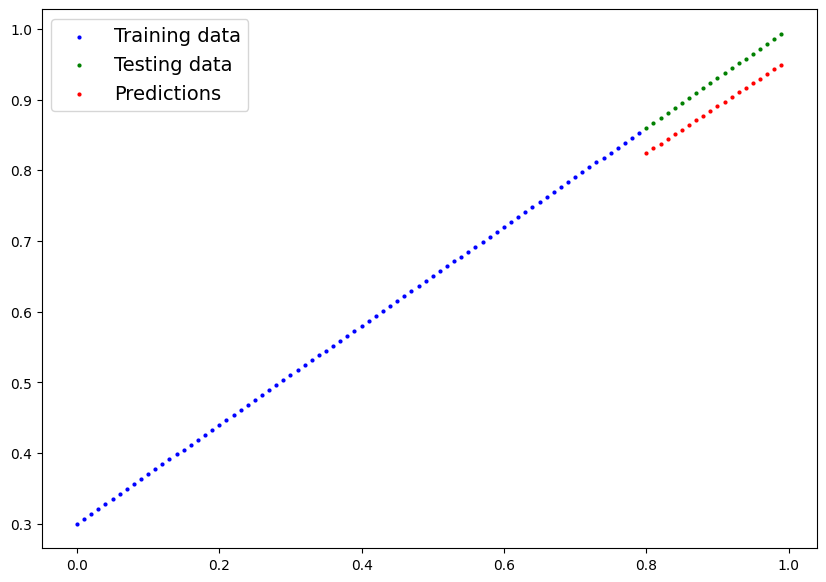

In [48]:
# Turn on evaluaton mode
model_2.eval()

# Make predictions (inference_mode)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data = X_train_regression,
                train_labels = y_train_regression,
                test_data = X_test_regression,
                test_labels = y_test_regression,
                predictions = y_preds)

## 6. The missing piece: non-linearity

"what patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?


### 6.1 Recreating non-linear data (red and blue circles)


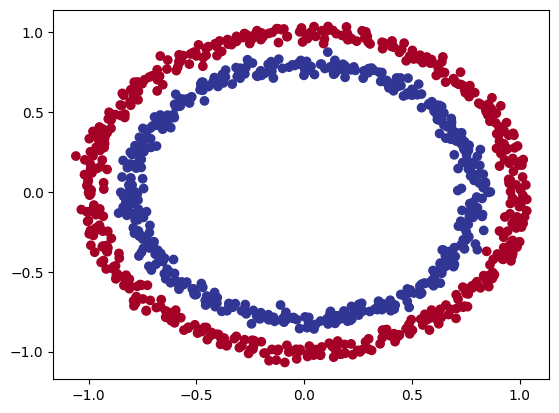

In [49]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

n_samples = 1000

X, y =  make_circles(n_samples,
                        noise=0.03,
                        random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [50]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non - linearity

* Linear = straight lines
* non-linear =  non straight lines -> graph is not a straight lines.


Artificial neural networks are a large combination of linear (straight) and non-linear (non-straight) functions which are potentially able to find patterns in data

In [51]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, X):
    # where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))
  

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

* this shows us all the parameters of our model_3

In [52]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr = 0.1)


### 6.3 Training a model with non-linearity

In [53]:
# random seeds 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# put all the data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### training
  model_3.train()

  # forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # calculate loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)
  
  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  # step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)
    
  # print what is happening
    if epoch % 100 ==0:
      print(f"Epoch: {epoch} | Loss: {loss:4f}, Acc: {acc:2f}% | Test Loss: {test_loss:4f}, Test Acc: {test_acc:2f}%")


Epoch: 0 | Loss: 0.692946, Acc: 50.000000% | Test Loss: 0.693188, Test Acc: 50.000000%


Epoch: 100 | Loss: 0.691153, Acc: 52.875000% | Test Loss: 0.691024, Test Acc: 52.500000%
Epoch: 200 | Loss: 0.689774, Acc: 53.375000% | Test Loss: 0.689396, Test Acc: 55.000000%
Epoch: 300 | Loss: 0.687950, Acc: 53.000000% | Test Loss: 0.687232, Test Acc: 56.000000%
Epoch: 400 | Loss: 0.685168, Acc: 52.750000% | Test Loss: 0.684115, Test Acc: 56.500000%
Epoch: 500 | Loss: 0.681022, Acc: 52.750000% | Test Loss: 0.679412, Test Acc: 56.500000%
Epoch: 600 | Loss: 0.675149, Acc: 54.500000% | Test Loss: 0.672851, Test Acc: 56.000000%
Epoch: 700 | Loss: 0.666589, Acc: 58.375000% | Test Loss: 0.663216, Test Acc: 59.000000%
Epoch: 800 | Loss: 0.651596, Acc: 64.000000% | Test Loss: 0.647569, Test Acc: 67.500000%
Epoch: 900 | Loss: 0.623623, Acc: 74.000000% | Test Loss: 0.621453, Test Acc: 79.000000%


### 6.4 Evaluating a model trained with non-linear activation functions

In [54]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10],y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

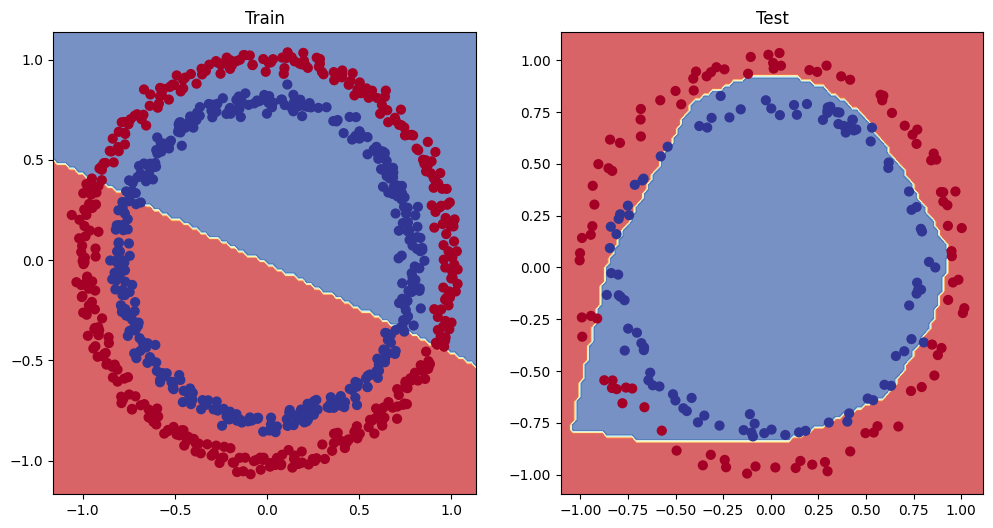

In [55]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train) # model_1 has no non-linearity
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test) # model_3 has non-linearity

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions


In [59]:
# Create a tensor
A = torch.arange(-10,10,1, dtype = torch.float32)
A.dtype

torch.float32

In [60]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

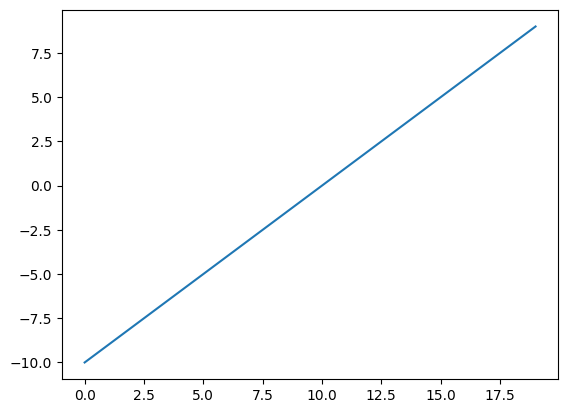

In [61]:
# visualize this tensor
plt.plot(A)

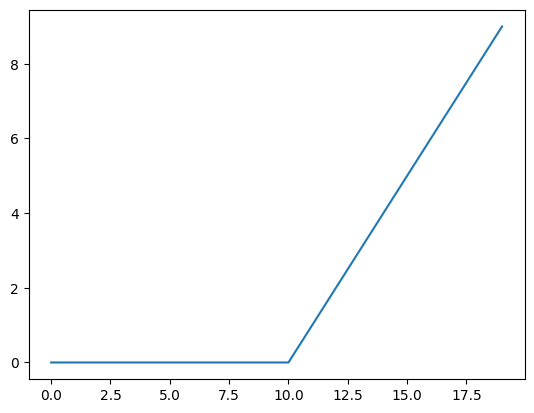

In [62]:
plt.plot(torch.relu(A))

In [65]:
def relu(X:torch.Tensor)->torch.Tensor:
  return torch.maximum(torch.tensor(0),X) # inputs must be tensors
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

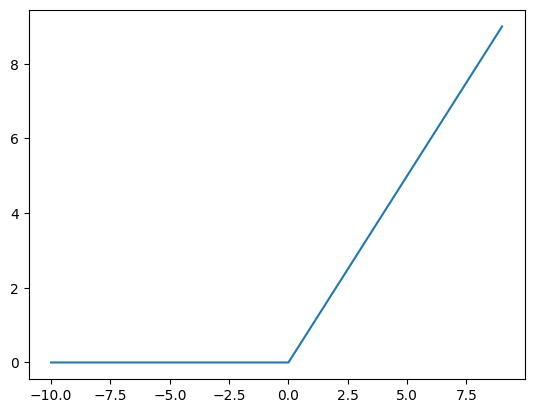

In [67]:
# plot the relu function
plt.plot(A,relu(A))

In [69]:
# now lets do the same for sigmoid
def sigmoid(X):
  return 1/(1+torch.exp(-X))


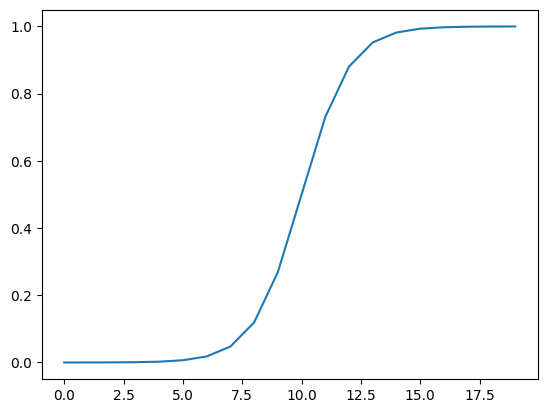

In [70]:
plt.plot(sigmoid(A))